In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2 as cv
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


# Reading Training Data

In [2]:
DATADIR = '/home/hasan/DATA SET/cat dog/train'
CATEGORIES = ['cat','dog']

In [3]:
training_data = []

def create_training_data():
    for categories in CATEGORIES:
        path = os.path.join(DATADIR, categories)
        n_class = CATEGORIES.index(categories)
        for images in os.listdir(path):
            try:
                image_array = cv.imread(os.path.join(path,images), cv.IMREAD_GRAYSCALE)

                new_array = cv.resize(image_array,(128, 128))
                training_data.append([new_array, n_class])
            except Exception as e:
                pass

create_training_data()

# Reading Testing Data

In [4]:
DATADIR = '/home/hasan/DATA SET/cat dog/test'
CATEGORIES = ['cat','dog']

In [5]:
testing_data = []

def create_Testing_data():
    for categories in CATEGORIES:
        path = os.path.join(DATADIR, categories)
        n_class = CATEGORIES.index(categories)
        for images in os.listdir(path):
            try:
                image_array = cv.imread(os.path.join(path,images), cv.IMREAD_GRAYSCALE)

                new_array = cv.resize(image_array,(128, 128))
                testing_data.append([new_array, n_class])
            except Exception as e:
                pass

create_Testing_data()

# Dividing Training Data into feature and label

In [6]:
#for train data
xtrain = []
ytrain = []
for feature, label in training_data:
    xtrain.append(feature)
    ytrain.append(label)
    
    
xtest = []
ytest = []
for feature, label in testing_data:
    xtest.append(feature)
    ytest.append(label)
    

# Converting to array and resizing data

In [7]:
#train data
xtrain = np.array(xtrain).reshape(-1,128,128,1)
xtest = np.array(xtest).reshape(-1,128,128,1)

print('Shape of train_feature :',xtrain.shape)
print('Shape of the test_feature :',xtest.shape)
print('Shape of train_label :', len(ytrain))
print('Shape of test_label :', len(ytest))

Shape of train_feature : (18705, 128, 128, 1)
Shape of the test_feature : (6241, 128, 128, 1)
Shape of train_label : 18705
Shape of test_label : 6241


# Encoding the label data

In [9]:
#convert label to one hot encoding
ytrain_one_hot = to_categorical(ytrain, num_classes=2)
ytest_one_hot = to_categorical(ytest, num_classes=2)
print(ytrain_one_hot[1])
print(ytest_one_hot[1])

[1. 0.]
[1. 0.]


In [10]:
#spliting training data to train and vlidation
Xtrain, xvalid, Ytrain, yvalid = train_test_split(xtrain, ytrain_one_hot, 
                                                  test_size=.25, 
                                                  random_state=0)

# Model

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [13]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

# ImageDataGenerator

In [ ]:
#for train data
train_datagen = ImageDataGenerator(zoom_range=.2,
                                   shear_range=.2,
                                   horizontal_flip=True
                                   )
train_datagen.fit(Xtrain)

#for validation data
valid_datagen = ImageDataGenerator(zoom_range=.2,
                                   shear_range=.2,
                                   horizontal_flip=True
                                   )
valid_datagen.flow(xvalid)

# Training The Model

In [ ]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [ ]:
model_fit = model.fit(train_datagen.flow(Xtrain,Ytrain), batch_size=70, 
                     epochs=5, verbose=1, 
                     validation_data=valid_datagen.flow(xvalid, yvalid), 
                     callbacks = [callbacks]
                     )

# Evaluating with Test Data

In [ ]:
test_eval = model.evaluate(xtest, ytest_one_hot, verbose=1)

print('Test loss :',test_eval[0])
print('Test accuracy :',test_eval[1])

# Drawing Training and Validation curve

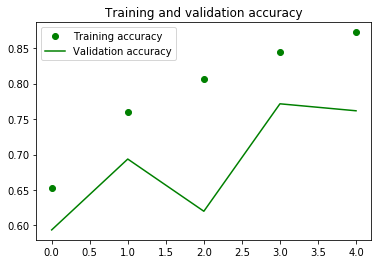

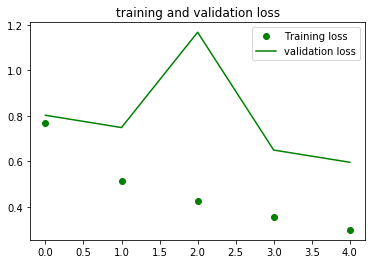

In [20]:
accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Predicting with Test Data

In [21]:
#this is float value of the class
predicted = model.predict(xtest)

#converting float value to integer value
predicted = np.argmax(np.round(predicted), axis=1)
print('Shape of predicted data :',predicted.shape)
print('Predicted values :',predicted)

Shape of predicted data : (6241,)
Predicted values : [1 1 0 ... 1 1 1]


# Classification Report

In [26]:
print(classification_report(ytest,predicted))

              precision    recall  f1-score   support

           0       0.93      0.53      0.68      3220
           1       0.66      0.96      0.78      3021

    accuracy                           0.74      6241
   macro avg       0.80      0.75      0.73      6241
weighted avg       0.80      0.74      0.73      6241



# Confusion Matrix

Text(33.0, 0.5, 'predicted label')

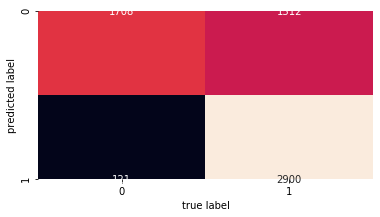

In [32]:
#printing confusion matrix
mat = confusion_matrix(ytest, predicted)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

# Printing some correct Image

Found 4608 correct labels 


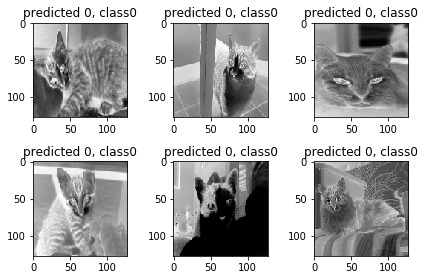

In [33]:
#printing the total correct data
correct_data = np.where(predicted==ytest)[0]
print('Found %d correct labels '%len(correct_data))

#printing some correct data
for i, correct in enumerate(correct_data[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(xtest[correct].reshape(128,128), cmap='binary', interpolation='none')
    plt.title('predicted {}, class{}'.format(predicted[correct], ytest[correct]))
    plt.tight_layout()



# Printing some incorrect Image

Found 1633 incorrect labels 


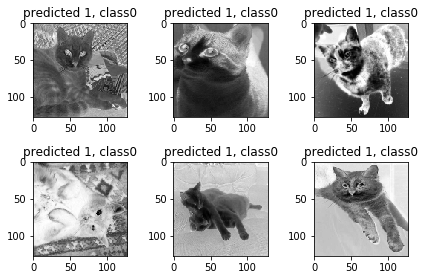

In [35]:
#printing the total correct data
incorrect_data = np.where(predicted!=ytest)[0]
print('Found %d incorrect labels '%len(incorrect_data))

#printing some correct data
for i, incorrect in enumerate(incorrect_data[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(xtest[incorrect].reshape(128,128), cmap='binary', interpolation='none')
    plt.title('predicted {}, class{}'.format(predicted[incorrect], ytest[incorrect]))
    plt.tight_layout()

Note: I don't run the full code because of my PC configuration.                                                       
      If you want to see a good result please run the full model.